In [1]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
import clawpack.petclaw as pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

plt.style.use(['dark_background'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

# The purpose here is to test Dirichlet boundary conditions

In [2]:
filepath = '../Paper_3/flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def get_bathymetry(filepath, resolution=1):
    retval = collections.OrderedDict()
    z = []
    with open(filepath) as f:
        for line in f:
            values = line.split()
            if is_number(values[0])==False:
                if float(values[1]).is_integer():
                    retval[values[0]]=int(values[1])
                else:
                    retval[values[0]]=float(values[1])
            else:
                z.append(float(values[0]))
    z = np.array(z)
    print('Z: {0}'.format(len(z)))
    xmax = float(retval['nrows']) * retval['cellsize']
    nx = retval['nrows']
    dx = retval['cellsize']
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    x = np.linspace(0, nx*dx, num=len(z))
    f = interp1d(x, z)
    xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
    znew = f(xnew)
    nx = len(xnew)

    return znew,xnew

## Now for calibration

Based on the documentation in Weibe the flow conditions for A3DOWN is as follows:

| Stage | Qc1 | Qc1 |

| 32 cm | 0.045 | 0.020 |

In [3]:
# 32 cm Case 
Qc132 = 0.045
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B


# Print out the unit flows
print(q20cm, q32cm)

0.07894736842105263 0.17763157894736842


### Calibrate 32 cm flow first

The flow conditions reported in Table 4.1 are based on the equalibrium conditions at the start and final conditions. Therefore we need to perform the calibration based on the 32 cm flow as our dunes are based on these conditions. 

In [4]:
z,x = get_bathymetry(filepath,4)

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=100000)
sws.set_state_domain(x,z)
sws.set_mannings_source_term(mannings=0.048, slope=1.26/1000.)

#sws.set_boundary_conditions()
hout = 0.357
Qin = q32cm

sws.set_Dirichlet_BC(hout,Qin)
sws.set_inital_conditions(hout, 0.0)
sws.set_controller(tfinal=300., num_output_times=3)
sws.run()
cntrl = sws.get_controller()



Z: 87
2019-04-22 03:29:25,205 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-22 03:29:32,135 INFO CLAW: Solution 1 computed for time t=100.000000
2019-04-22 03:29:39,373 INFO CLAW: Solution 2 computed for time t=200.000000
2019-04-22 03:29:46,315 INFO CLAW: Solution 3 computed for time t=300.000000


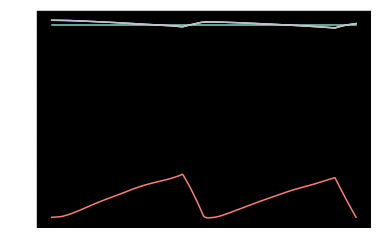

In [5]:
for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + z
    plt.plot(x,surf)
plt.plot(x,z)

plt.style.use(['dark_background'])

In [6]:
final_time = cntrl.num_output_times

depth = cntrl.frames[final_time].q[0,:]
surf = cntrl.frames[final_time].q[0,:] + z
u = cntrl.frames[final_time].q[1,:]/depth
print('The mean depth is 0.320 cm and the mean velocity is 0.561 m/s')
print('h: {0}  and  u: {1}'.format(depth.mean(),u.mean()))

The mean depth is 0.320 cm and the mean velocity is 0.561 m/s
h: 0.31950032128033057  and  u: 0.5599592648380952
